In [19]:
import csv
import os
import re
import pandas as pd
import argparse
import json
from utils.csv_utils import sort_csv_by_column


def load_json_filenames(json_dir):
    """Takes a path to a directory with JSONs, then adds all of the paths of
    the JSONs files in that directory to the filenames list, which is returned.
    
    Parameters:
        json_dir - String containing file system location of JSON files.
    Returns:
        filenames - Updated list of JSON file paths.
    """
    filenames = []
    # Scan recursively over all tsv files in a directory
    for folder, subfolders, files in os.walk(json_dir):
        for file in files:
            if file.endswith('.json') and 'checkpoint' not in file:
                #Add all the .pdf filenames to a list
                filename = os.path.join(folder, file)
                filenames.append(filename)
                
    return filenames

def convert_JSON_to_df(filename):
    """Takes a file path string to a JSON file outputted by Cloud Vision and
    converts that JSON to a Pandas Dataframe.
    
    Parameters:
        filename: String of the location of the JSON file.
    Returns:
        df: A pandas dataframe containing relevant information from the JSON
        files
    """
    
    # Opening JSON file and store it in dictionary
    with open(filename) as f:
        data = json.load(f)
    # Create new dataframe and set the header
    df = pd.DataFrame(columns=[
        'level', 'page_num', 'block_num', 'par_num', 'line_num', 'word_num',
        'left', 'top', 'width', 'height', 'conf', 'text'
    ])

    # Loop through the dictionary and extract text data and positional data
    for i in range(1, len(data['textAnnotations'])):
        text = data['textAnnotations'][i]['description']
        conf = data['textAnnotations'][i]['confidence']
        top_l = data['textAnnotations'][i]['boundingPoly']['vertices'][0]
        top_r = data['textAnnotations'][i]['boundingPoly']['vertices'][1]
        bottom_r = data['textAnnotations'][i]['boundingPoly']['vertices'][2]
        bottom_l = data['textAnnotations'][i]['boundingPoly']['vertices'][3]
        # Use bounding box vertices to calculate the left-most and top-most 
        # coordinate of each word, and the width and height of the words
        left = min(top_l['x'], bottom_l['x'])
        right = max(top_r['x'], bottom_r['x'])
        top = min(top_l['y'], top_r['y'])
        bottom = max(bottom_l['y'], bottom_r['y'])
        width = right - left
        height = bottom - top
        # Add the information to the dataframe
        df.loc[len(df.index)] = ['json', '1', '0', '0', '0', '0', left, top, width, height, conf, text]
    return df


def left_is_close(list1, list2, dist):    
    # First determine the leftmost text out of the two, then use that to 
    # check if the words should be joined together.
    if list1[6] < list2[6]:
        return (abs((list1[6] + list1[8]) - list2[6]) <= dist)
    else: 
        return (abs((list2[6] + list2[8]) - list1[6]) <= dist)
    
def top_is_close(line1, line2, dist):
    # Determine if the top coordinates of the two lines are within dist of
    # each other
    return (abs((int(line1[7]) + int(line1[9])) - 
                (int(line2[7]) + int(line2[9]))) <= dist)

def combine_lines(list1, list2):
    # Calculate the new coordinate information for combined text
    left = min(list1[6], list2[6])
    top = min(list1[7], list2[7])
    height = max(list1[9], list2[9])
    conf = ((list1[10] / 100) * (list2[10]/ 100)) * 100
    
    # Ensure that the lists can be passed to this function in any order
    if left == list1[6]:
        width = abs((list2[6] + list2[8]) - list1[6])
        text = f'{list1[11]} {list2[11]}'
    else:
        width = abs((list1[6] + list1[8]) - list2[6])
        text = f'{list2[11]} {list1[11]}'

    # Change the elements of the new list to all strings again, and return
    combined_list = list1[:6].copy()
    combined_list.extend([left, top, width, height, conf, text])
    
    return combined_list
    
    
def clean_dataframe(df):
    # Remove all text entries that are set as 'Nan'
    tmp_df = df.dropna(subset=['text'])
    # Filter out the rows of every text entry that contains spaces and/or '|'
    filtered = tmp_df[tmp_df.text.str.fullmatch('\ *\|?')].index
    # Drop the rows that were just filtered out
    filtered_df = tmp_df.drop(filtered)
    mask = (filtered_df.width * filtered_df.height) < 100
    new_df = filtered_df[~mask]
    return new_df

def realign_text(orig_df, left_dist_def, top_dist_def):
    # Clean the dataframe
    df = clean_dataframe(orig_df)
    # Convert the dataframe to a list
    ref_list = df.values.tolist()
    realigned = ref_list.copy()
    # Keep track of whether or not any changes were made in the latest 
    # iteration. Initialize to True so the while-loop will start.
    modified = True
    # Continue realigning the text until no changes are made
    while modified:
        # Reset to false for beginning of loop
        modified = False
        # Compare every row to every other row only once. Do not compare a row 
        # to itself
        for index, item1 in enumerate(ref_list):
            for item2 in ref_list[index+1:]:
                # Searching for special entires
                if re.search('NO.*', item1[11], re.IGNORECASE) and item1[7] < 220 and item1[7]> 125:
                    left_dist = left_dist_def + 200
                elif re.search('TWP\ ?\.?\ ?[0-9]+[A-Z]?', item1[11],  re.IGNORECASE):
                    left_dist = left_dist_def + 100
                elif re.search('RGE\ ?\.?\ ?[0-9]{1,3}[A-Z]?', item1[11],  re.IGNORECASE):
                    left_dist = left_dist_def + 100
                elif re.search('POOL\ *.*', item1[11], re.IGNORECASE) and item1[7] < 100:
                    left_dist = left_dist_def + 100
                elif re.search('COUNTY\ *.*', item1[11], re.IGNORECASE) and item1[7] < 100:
                    left_dist = left_dist_def + 100
                elif re.search('(OPR|OPERATOR):?\ ?.*', item1[11], re.IGNORECASE):
                    left_dist = left_dist_def + 100
                elif re.search('CSG:?\ ?', item1[11], re.IGNORECASE):
                    left_dist = left_dist_def + 70
                elif re.search('(NL|SL|EL|WL)\.\ ?[0-9]+', item1[11]):
                    left_dist = left_dist_def + 70
                else:
                    left_dist = left_dist_def

                top_dist = top_dist_def
                # Check if the two rows being compared are 'close'
                if top_is_close(item1, item2, top_dist) and left_is_close(item1, item2, left_dist):
                    # The realigned list is going to become shorter, so we need to
                    # ensure that the item we are comparing is still in the
                    # realigned list.
                    try:
                        modified = True # Changes have been made
                        # Get the positions of the two lines of text that will be
                        # combined
                        first_pos = realigned.index(item1)
                        second_pos = realigned.index(item2)
                    except ValueError:
                        # At least one of the lines were removed
                        continue

                    # Ensure that we combine the text in the right order
                    if int(item1[6]) < int(item2[6]):
                        realigned[first_pos] = combine_lines(item1, item2)
                        realigned.pop(second_pos)
                    else:
                        realigned[second_pos] = combine_lines(item1, item2)
                        realigned.pop(first_pos)
        ref_list = realigned.copy()
                
    return pd.DataFrame(data=realigned, columns=[
        'level', 'page_num', 'block_num', 'par_num', 'line_num', 'word_num',
        'left', 'top', 'width', 'height', 'conf', 'text'
        ])


def inside_DST_block_t3(line):
    if line[6] > 413 or line[7] < 730:
        return False
    else:
        return True


def setLocation(parsed):
        # Make sure to separate the township, range, and section from the pool
        # and county
        if len(parsed['Location']) > 0:
            parsed['Location'] = ', ' + parsed['Location']
        # Set township, range and section
        if parsed['Section']:
            parsed['Location'] = ' ' + parsed['Section'] + parsed['Location']
        if parsed['Range']:
            parsed['Location'] = ' ' + parsed['Range'] + parsed['Location']
        if parsed['Township']:
            parsed['Location'] = parsed['Township'] + parsed['Location']
        if parsed['QtrQtr']:
            parsed['Location'] = parsed['Location'] + ' QtrQtr: ' + parsed['QtrQtr']
        if parsed['pool'] and re.search('POOL\ ?[A-Z]+', parsed['pool'], re.IGNORECASE):
            parsed['Location'] = parsed['Location'] +  ', ' + parsed['pool']
        if parsed['county'] and re.search('COUNTY\ ?[A-Z]+', parsed['county'], re.IGNORECASE):
            parsed['Location'] = parsed['Location'] + ', ' + parsed['county']
        
        # Remove any double spaces
        parsed['Location'] = re.sub('  ', ' ', parsed['Location'])
        parsed['Location'] = re.sub('POOL', 'POOL:', parsed['Location'])
        parsed['Location'] = re.sub('COUNTY', 'COUNTY:', parsed['Location'])
        
        return parsed

    
def setLocationFootage(parsed):
        if parsed['NSFootage']:
            parsed['LocationFootage'] += parsed['NSFootage']
        if parsed['EWFootage']:
            parsed['LocationFootage'] += ' ' + parsed['EWFootage']
        
        # Remove any double spaces
        parsed['LocationFootage'] = re.sub('  ', ' ', parsed['LocationFootage'])
        
        return parsed
    

def parse_lines(df, parsed):
    """Loops through all of the text lines passed to it and parses the text
    into a Card object.
    
    Parameters:
        df - List of strings. 1 string = 1 text line from a file
        parsed - Card object that the parsed text will be entered into.
    Returns:
        card - Card object with entered parsed text.
    """
    formation_list = ['SURFACE','WASATCH','FT. UNION','LANCE','FOX HILLS','MESA VRD','PARKMAN','SHANNON',
        'EAGLE','NIOBRARA','FRONTIER','WALL CK','GR.NHORN','MOWRY','MUDDY','N.CASTLE','DAKOTA','FALL RVR',
        'LAKOTA','CLOVERLY','MORRISON','SUNDANCE','CHUGWTR','SPEARFISH','Alcova','ALCOVA','EMBAR','TENSLEEP',
        'MINLUSA','AMSDEN','MADISON']
    
    for line in df.itertuples(index=False):
        text = line[11]
        # Extract any API number
        api = re.search('(49)\-?\ ?0[0-9]{2}\-?\ ?([0-9]{5})\-?\ ?([0-9]{4})?', text)
        if api:
            parsed["APINum"] = api.group()

        # Extract the well's name/number
        wellName = re.search('NO.*', text, re.IGNORECASE)
        if wellName and line[7] < 220 and line[7] > 125:
            parsed["WellName"] = wellName.group()
            parsed["WellName"] = re.sub("(NO|\.)", "", parsed["WellName"])
        
        # Extract the well's operator
        operator = re.search('(OPERATOR|OPR)\.?\ ?.*', text, re.IGNORECASE)
        if operator and line[7] < 220:
            parsed["Operator"] = operator.group()
        
        # Extract the township location of the well
        township = re.search('TWP\ ?\.?\ ?[0-9]+[A-Z]?', text,  re.IGNORECASE)
        if township and line[7] < 150:
            parsed["Township"] =  township.group()

        # Extract the range location of the well
        Range = re.search('RGE\ ?\.?\ ?[0-9O]+[A-Z]?', text,  re.IGNORECASE)
        if Range and line[7] < 150:
            parsed["Range"] = Range.group()

        # Extract the township section of the well
        section = re.search('SEC\.?\ ?[0-9]{1,2}', text, re.IGNORECASE)
        if section and line[7] < 150:
            parsed["Section"] = section.group()

        # Extract the North line footage of the well
        NL = re.search('NL\.?\ ?[0-9]+', text, re.IGNORECASE)
        if NL and line[7] < 300:
            parsed["NSFootage"] = NL.group()

        # Extract the South line footage of the well
        SL = re.search('SL\.?\ ?[0-9]+', text, re.IGNORECASE)
        if SL and line[7] < 300:
            if parsed["NSFootage"] != "": 
                parsed["NSFootage"] += " "
            parsed["NSFootage"] += SL.group()

        # Extract the East line footage of the well
        EL = re.search('EL\.?\ ?[0-9]+', text, re.IGNORECASE)
        if EL and line[7] < 300:
            parsed["EWFootage"] = EL.group()

        # Extract the West line footage of the well
        WL = re.search('WL\.?\ ?[0-9]+', text, re.IGNORECASE)
        if WL and line[7] < 300:
            if parsed["EWFootage"] != "":
                parsed["EWFootage"] += " "
            parsed["EWFootage"] += WL.group()

        # Extract the NSFootage of the well
        Qtr_Qtr = re.search('(C\ |C\/2\ )?((((N|E|S|W)\/2\ ?)|(NE|NW|SE|SW))\ ?){2,3}', text, re.IGNORECASE)
        if Qtr_Qtr and line[7] < 150 and line[6] < 250:
            parsed["QtrQtr"] = Qtr_Qtr.group()
        
        # Extract the elevation of the well
        elev = re.search('ELEV(.| )+[0-9A-Z]+', text, re.IGNORECASE)
        if elev and line[7] < 300:
            parsed["Elevation"] = elev.group()
        
        # Extract the spud date
        spud = re.search('COMM\.?\ ?\d{1,2}(\/|\-)\d{1,2}(\/|\-)\d{2,4}', text, re.IGNORECASE)
        if spud:
            parsed["SpudDate"] = spud.group()

        # Extract the completion date
        comp = re.search('COMP\.?\ ?\d{1,2}(\/|\-)\d{1,2}(\/|\-)\d{2,4}', text, re.IGNORECASE)
        if comp:
            parsed["CompDate"] = comp.group()


        # Extract the Formation TD's
        for formation in formation_list:
            pattern = formation+'\.?\ *[0-9]{1,4}'
            formationTD = re.search(pattern, text)
            if formationTD:
                parsed["TDFormation"] += ' ' + formationTD.group()
        
        # Extract the total depth
        TD = re.search('(T|7)\.?D\.?\ ?[0-9]{2,4}', text, re.IGNORECASE)
        if TD:
            parsed["TotalDepth"] = TD.group()
        
        # Extract the plug back
        PB = re.search('P\.?B\.?\ ?[0-9]{2,4}', text, re.IGNORECASE)
        if PB:
            parsed["PlugBackDepth"] = PB.group()
        
        # Extract some casing information
        casing = re.search('[0-9]{1,2}"\ ?[0-9]\/[0-9]\ ?[0-9]*', text)
        if casing:
            parsed["Casing"] += ' ' + casing.group()
    
        # Extract the pool (field) location info
        pool = re.search('POOL\ *[A-Z0-9\-\_]*', text, re.IGNORECASE)
        if pool and line[7] < 100:
            parsed["pool"] = pool.group();

        # Extract the county location info
        county = re.search('COUNTY\ *[A-Z0-9\-\_]*', text, re.IGNORECASE)
        if county and line[7] < 100:
            parsed["county"] = county.group()
            
        if re.search('Reissued', text, re.IGNORECASE):
            parsed['Reeissued'] = text
            
        if inside_DST_block_t3(line):
            if parsed['DSTS_Cores'] == '':
                parsed['DSTS_Cores'] = line[11]
            else:
                parsed['DSTS_Cores'] += ' ' + line[11]
    
    return parsed

def main():
    # Parse input and output directory options
    parser = argparse.ArgumentParser()
    parser.add_argument("-i", "--input", required=True,
                        help="Path to directory containing text files")
    parser.add_argument("-o", "--output", required=True,
                        help="File path of CSV will be outputted to")
    args = vars(parser.parse_args())
    
    # Make sure that the output is a .csv file
    if args["output"][-4:] != '.csv':
        print("ERROR: Output file must be .csv!", file=sys.stderr)
        return
    
    # Create the .csv file
    output_csv = pd.DataFrame(columns=['DocumentID','APINum','WellName',
        'Operator','Location','Township','Range','Section','NSFootage','EWFootage','QtrQtr',
        'LocationFootage','Elevation','SpudDate','CompDate','TDFormation','TotalDepth',
        'PlugBackDepth','Casing','InitProd','ProdZone','CardNumber','WellStatus','Reissued',
        'DSTS_Cores'])
    filenames = load_json_filenames(args["input"])
    count = 0
    # Parse all the text files in the input directory into the csv
    for filename in filenames:
        # Skip non-json files
        if not filename.endswith('.json'):
            continue

        file = os.path.join(args["input"], filename)

        CardDetails = {'DocumentID':os.path.basename(filename),\
        'APINum':'','WellName':'','Operator':'','Location':'',\
        'Township':'','Range':'','Section':'','NSFootage':'',\
        'EWFootage':'','QtrQtr':'','LocationFootage':'','Elevation':'',\
        'SpudDate':'','CompDate':'','TDFormation':'','TotalDepth':'',\
        'PlugBackDepth':'','Casing':'','InitProd':'','ProdZone':'',\
        'CardNumber':'','WellStatus':'','Reissued':'','DSTS_Cores':'', 'pool':'', 'county':''}
        
        jsondf = convert_JSON_to_df(filename)
        
        
        ##############################################################################################
        # Change the text column in the csv to be all strings.
        jsondf.dropna()
        jsondf['text'] = jsondf['text'].apply(str)
        
        #Code to remove all the "nan"s that show up in the output
        mask = jsondf['text'] == 'nan'
        jsondf = jsondf[~mask]
        
        jsondf['text'] = jsondf['text'].replace('[,.\/\\?<>{}"`!@#$%^*+=\[\]]', "", regex=True)
        jsondf['text'] = jsondf['text'].replace("'", "", regex=True)
        jsondf['text'] = jsondf['text'].replace(";", ":", regex=True)
        jsondf['text'] = jsondf['text'].replace("~", "-", regex=True)
 
        # Realign the text
        realigned = realign_text(jsondf, left_dist_def=60, top_dist_def=20)
        
        realigned['text'] = realigned['text'].replace('\ \.', '.', regex=True)
        
        # Find any matching text lines
        parsed = parse_lines(realigned, CardDetails)
        # Set the location information
        parsed = setLocation(parsed)
        parsed = setLocationFootage(parsed)
        
        del parsed['county']
        del parsed['pool']
        
        # Deal with parsed text after parsing has been completed.
        # Replace any occurence of & in these names with 8
        parsed["WellName"] = re.sub("&", "8", parsed["WellName"])
        parsed["Operator"] = re.sub("&", "8", parsed["Operator"])
        
        # Clean up DST and Core info
        parsed["DSTS_Cores"] = re.sub("[\n\t\r]", "", parsed["DSTS_Cores"])
        parsed["DSTS_Cores"] = re.sub("  ", " ", parsed["DSTS_Cores"])
        
        # Add Formation Tops Info
        parsed["TDFormation"] = re.sub("  ", " ", parsed["TDFormation"])
        
        
        # Append parsed card information to spreadsheet
        df_parsed = pd.DataFrame([parsed])
        output_csv = pd.concat([output_csv, df_parsed], ignore_index=True)

    # Output the csv file
    output_csv.to_csv(args["output"], index=False)
    sort_csv_by_column(args["output"], 0, True)
    
    print("Done parsing cards")
    return

# if __name__ =='__main__':
#     main()

left: 18, width: 737, top: 123, height: 25, text: CNE NW SEC 20 TWP 39n RGE 78w SPOTTED
left: 37, width: 414, top: 161, height: 28, text: OPERATOR Sinclair Wyoming
left: 36, width: 296, top: 196, height: 23, text: NO B - 9 Ch038019b
left: 37, width: 167, top: 235, height: 20, text: NL 654 SL
left: 39, width: 58, top: 513, height: 12, text: CONTR
left: 38, width: 53, top: 552, height: 13, text: COMM
left: 39, width: 36, top: 631, height: 12, text: NIP
left: 39, width: 42, top: 672, height: 11, text: ACID
left: 38, width: 35, top: 710, height: 13, text: AIP
left: 218, width: 278, top: 55, height: 21, text: POOL SALT CREEK
left: 217, width: 230, top: 90, height: 25, text: COUNTY NATRONA
left: 318, width: 159, top: 22, height: 16, text: WYOMING
left: 37, width: 146, top: 753, height: 24, text: S - USGS
left: 251, width: 19, top: 331, height: 12, text: 15
left: 251, width: 21, top: 356, height: 10, text: 12
left: 252, width: 21, top: 381, height: 11, text: 10
left: 263, width: 11, top: 431,

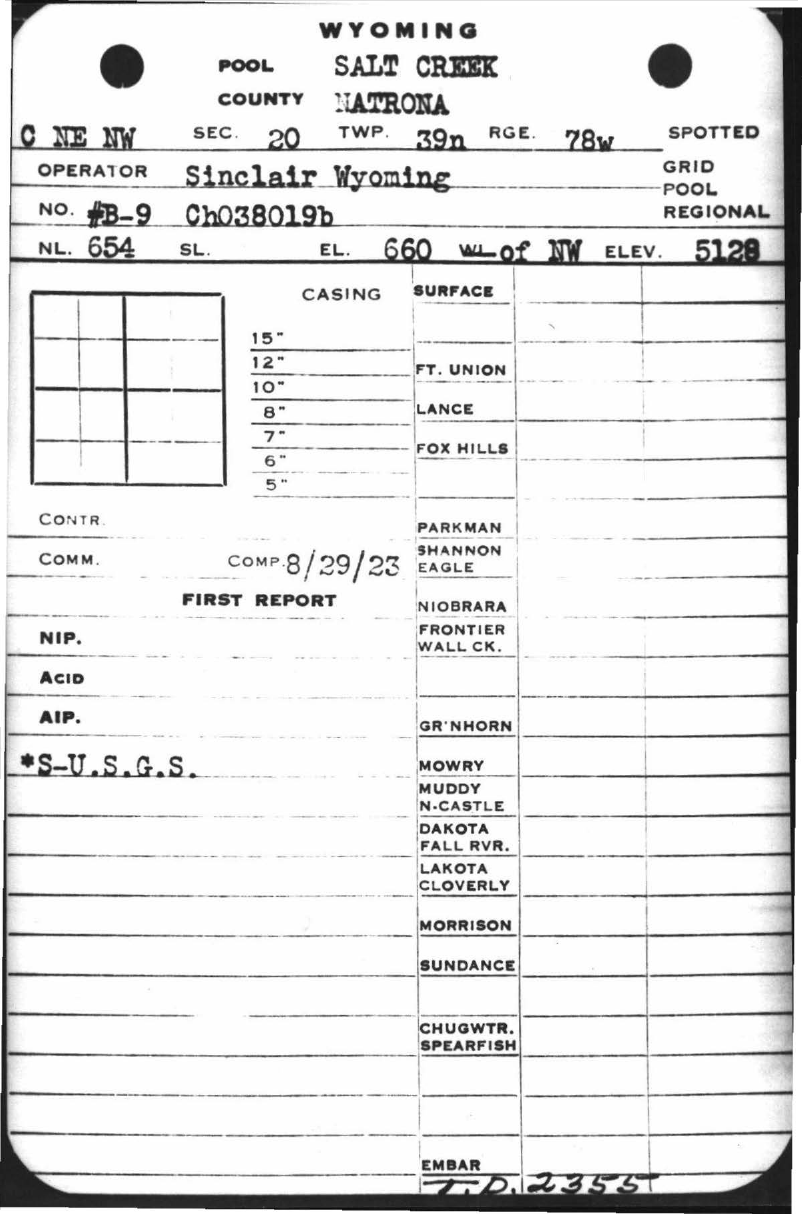

In [36]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from PIL import Image
from pdf2image import convert_from_path
pd.set_option('expand_frame_repr', False)

BoxNo='Box9'
imgDir = os.path.join('/pfs/tc1/project/arcc-students/OilWellProject2023.Summer/vert_pages/', BoxNo)
imgFile = '425-0296.pdf_page_1.pdf'

poppler = '/pfs/tc1/project/arcc-students/csloan5/environments/GPU_env/bin/'
image = convert_from_path(os.path.join(imgDir,imgFile), poppler_path=poppler)[0]

boundingBox=True
boundingBox=False


json_dir = '/pfs/tc1/project/arcc-students/OilWellProject2023.Summer/Vert_Jsons'
json_filename = os.path.join(json_dir, imgFile[:-4] + '.json')

CardDetails = {'DocumentID':'',\
        'APINum':'','WellName':'','Operator':'','Location':'',\
        'Township':'','Range':'','Section':'','NSFootage':'',\
        'EWFootage':'','QtrQtr':'','LocationFootage':'','Elevation':'',\
        'SpudDate':'','CompDate':'','TDFormation':'','TotalDepth':'',\
        'PlugBackDepth':'','Casing':'','InitProd':'','ProdZone':'',\
        'CardNumber':'','WellStatus':'','Reissued':'','DSTS_Cores':'', 'pool':'', 'county':''}
        
jsondf = convert_JSON_to_df(json_filename)


##############################################################################################
# Change the text column in the csv to be all strings.
jsondf.dropna()
jsondf['text'] = jsondf['text'].apply(str)

#Code to remove all the "nan"s that show up in the output
mask = jsondf['text'] == 'nan'
jsondf = jsondf[~mask]

jsondf['text'] = jsondf['text'].apply(str)

jsondf['text'] = jsondf['text'].replace('[,.\\?<>{}"`!@#$%^*+=\[\]]', "", regex=True)
jsondf['text'] = jsondf['text'].replace("'", "", regex=True)
jsondf['text'] = jsondf['text'].replace(";", ":", regex=True)
jsondf['text'] = jsondf['text'].replace("~", "-", regex=True)

Formations = ""
DSTs_and_Cores = ""
# Grab DSTS and Cores Text section before realigning.
for line in jsondf.itertuples(index=False):
    # If it is inside the DST block
    if inside_DST_block_t3(line):
        # Make sure we don't go to far down
        if DSTs_and_Cores == "":
            DSTs_and_Cores = line[11]
        else:
            DSTs_and_Cores += ' ' + line[11]


# Realign the text
realigned = realign_text(jsondf, left_dist_def=60, top_dist_def=20)
realigned['text'] = realigned['text'].replace('\ \.', '.', regex=True)
# Find any matching text lines
parsed = parse_lines(realigned, CardDetails)
# Set the location information
parsed = setLocation(parsed)
parsed = setLocationFootage(parsed)

# Deal with parsed text after parsing has been completed.
# Replace any occurence of & in these names with 8
parsed["WellName"] = re.sub("&", "8", parsed["WellName"])
parsed["Operator"] = re.sub("&", "8", parsed["Operator"])

# Clean up DST and Core info
parsed["DSTS_Cores"] = re.sub("[\n\t\r]", "", parsed["DSTS_Cores"])
parsed["DSTS_Cores"] = re.sub("  ", " ", parsed["DSTS_Cores"])

# Add Formation Tops Info
parsed["TDFormation"] = re.sub("  ", " ", parsed["TDFormation"])


# realigned = realign_text(csv, left_dist_def=30, top_dist_def=10)
for line in realigned.itertuples(index=False):
    print (f"left: {line[6]}, width: {line[8]}, top: {line[7]}, height: {line[9]}, text: {line[11]}")


print(f"API: {parsed['APINum']}\nName: {parsed['WellName']}\nOPR: {parsed['Operator']}\nLocation: {parsed['Location']}")
print(f"Township: {parsed['Township']}\nRange: {parsed['Range']}\nSection: {parsed['Section']}")
print(f"NS: {parsed['NSFootage']}\nEW: {parsed['EWFootage']}\nQtrQtr: {parsed['QtrQtr']}")
print(f"LocationFootage: {parsed['LocationFootage']}\nElevation: {parsed['Elevation']}\nSPUD: {parsed['SpudDate']}")
print(f"Comp: {parsed['CompDate']}\nFormations: {parsed['TDFormation']}\nTD: {parsed['TotalDepth']}")
print(f"PBTD: {parsed['PlugBackDepth']}\nCasing: {parsed['Casing']}\nInitProd: {parsed['InitProd']}")
print(f"ProdZone: {parsed['ProdZone']}\nCardNumber: {parsed['CardNumber']}\nStatus: {parsed['WellStatus']}")
print(f"Reissued: {parsed['Reissued']}\nDSTS_Cores: {parsed['DSTS_Cores']}")

if boundingBox:
    plt.imshow(image)

    # Get the current reference
    ax = plt.gca()
    ax.set_axis_off()
    ax.figure.set_size_inches(18.5, 10.5)
    # Create a Rectangle patch

    #         Left  Top  width  height
    coords = [43, 66, 104, 15]
    rect = Rectangle((coords[0], coords[1]), coords[2], coords[3], linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
else:
    image.show()